We will first take a look at why we always have a training and testing sets. Using the California housing datasets. The aim of this dataset is to predict the median value of houses in area in California using general real estate and geographical information.

In [1]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target

In [2]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [4]:
# Let's transform prices from the dollar range to the thousand dollars range. 

target *= 100
target.head()

0    452.6
1    358.5
2    352.1
3    341.3
4    342.2
Name: MedHouseVal, dtype: float64

Training error and testing error:: `Decision Tree Regressor`

In [6]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(data, target)

DecisionTreeRegressor(random_state=0)

In [7]:
# Mean Absolute Error
from sklearn.metrics import mean_absolute_error

target_predicted = regressor.predict(data)
score = mean_absolute_error(target, target_predicted)
print(f"On average, our regressor makes an error of {score:2f} k$")

On average, our regressor makes an error of 0.000000 k$


In [8]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0)

In [9]:
regressor.fit(data_train, target_train)

DecisionTreeRegressor(random_state=0)

### Now, we estimate the different types of errors

In [11]:
#TRAINING ERROR
target_predicted = regressor.predict(data_train)
score = mean_absolute_error(target_train, target_predicted)
print(f"The training error of our model is {score:.2f} k$")

The training error of our model is 0.00 k$


In [12]:
# TESTING ERROR
target_predicted = regressor.predict(data_test)
score = mean_absolute_error(target_test, target_predicted)
print(f"The testing error of our model is {score:.2f} k$")

The testing error of our model is 47.28 k$


The testing error is what we would expect from our model if it was used in a production environment. 

There are different cross-validation strategies, for now we are going to focus on one called "shuffle-split". At each iteration of this strategy we:

randomly shuffle the order of the samples of a copy of the full dataset;
split the shuffled dataset into a train and a test set;
train a new model on the train set;
evaluate the testing error on the test set.
We repeat this procedure n_splits times. Using n_splits=40 means that we will train 40 models in total and all of them will be discarded: we just record their statistical performance on each variant of the test set.

To evaluate the statistical performance of our regressor, we can use sklearn.model_selection.cross_validate with a sklearn.model_selection.ShuffleSplit object:

In [13]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=40, test_size=0.3, random_state=0)
cv_results = cross_validate(
    regressor, data, target, cv=cv, scoring="neg_mean_absolute_error")

In [14]:
import pandas as pd

cv_results = pd.DataFrame(cv_results)
cv_results.head()

,fit_time,score_time,test_score
0,0.116688,0.002992,-46.909797
1,0.109706,0.003989,-46.421170
2,0.109707,0.002992,-47.411089
3,0.106714,0.002993,-44.319824
4,0.107712,0.002992,-47.607875


In [15]:
cv_results["test_error"] = -cv_results["test_score"]

In [16]:
cv_results.head(10)

,fit_time,score_time,test_score,test_error
0,0.116688,0.002992,-46.909797,46.909797
1,0.109706,0.003989,-46.421170,46.421170
2,0.109707,0.002992,-47.411089,47.411089
3,0.106714,0.002993,-44.319824,44.319824
4,0.107712,0.002992,-47.607875,47.607875
5,0.107712,0.002993,-45.901300,45.901300
6,0.110704,0.002995,-46.572767,46.572767
7,0.110715,0.001984,-46.194585,46.194585
8,0.118684,0.002992,-45.590236,45.590236
9,0.114694,0.002993,-45.727998,45.727998


In [17]:
len(cv_results)

40

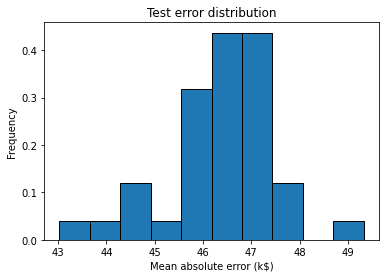

In [18]:
import matplotlib.pyplot as plt

cv_results["test_error"].plot.hist(bins=10, edgecolor="black", density=True)
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Test error distribution")

In [19]:
print(f"The mean cross-validated testing error is: "
      f"{cv_results['test_error'].mean():.2f} k$")

The mean cross-validated testing error is: 46.36 k$


In [20]:
print(f"The standard deviation of the testing error is: "
      f"{cv_results['test_error'].std():.2f} k$")

The standard deviation of the testing error is: 1.17 k$


Note that the standard deviation is much smaller than the mean: we could
summarize that our cross-validation estimate of the testing error is
46.36 +/- 1.17 k\\$.

If we were to train a single model on the full dataset (without
cross-validation) and then later had access to an unlimited amount of test
data, we would expect its true testing error to fall close to that
region.

While this information is interesting in itself, it should be contrasted to
the scale of the natural variability of the vector `target` in our dataset.

Let us plot the distribution of the target variable:

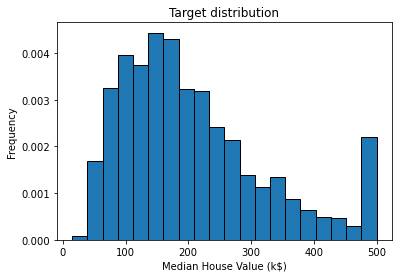

In [21]:
target.plot.hist(bins=20, edgecolor="black", density=True)
plt.xlabel("Median House Value (k$)")
_ = plt.title("Target distribution")

In [22]:
print(f"The standard deviation of the target is: {target.std():.2f} k$")

The standard deviation of the target is: 115.40 k$


Cross-validation trains and evaluates many models simultaneously. Since the number of elements in each of array of the output of `cross_validate` is a result of one of these `fit/score` procedures, it is possible to retrieve these fitted models for each of the splits/ folds by passing the option `return_estimator=True` in `cross_validate`.

In [24]:
cv_results = cross_validate(regressor, data, target, return_estimator=True)
cv_results

{'fit_time': array([0.2100215 , 0.17684793, 0.17057014, 0.20835805, 0.16962218]),
 'score_time': array([0.01015568, 0.        , 0.        , 0.        , 0.        ]),
 'estimator': [DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0)],
 'test_score': array([0.26291527, 0.41947109, 0.44492564, 0.23357874, 0.40788361])}

In [25]:
cv_results["estimator"]

[DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0)]

In [26]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(regressor, data, target)
scores

array([0.26291527, 0.41947109, 0.44492564, 0.23357874, 0.40788361])